In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
class AdamOptimizer:
    def __init__(self, alpha, params, beta1=0.9, beta2=0.999, epsilon=10e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.moments = []
        self.epoch = 0
        if not params:
            raise Exception("Parameters can't be undefined!")
        for i in range(len(params)):
            self.moments.append(
                {
                    'V': np.zeros_like(params[i]),
                    'S': np.zeros_like(params[i])
                }
            )

    def update(self, params=[], grads=[]):
        params_len = len(params)
        grads_len = len(grads)
        if params_len != grads_len or params_len == 0:
            raise Exception("Empty or Inconsistant Parameters and Gradients List!")

        self.epoch += 1

        for i in range(grads_len):
            # Update biased first moment estimate
            self.moments[i]['V'] = self.beta1 * self.moments[i]['V'] + (1 - self.beta1) * grads[i]
            # Update biased second raw moment estimate (RMSProp part)
            self.moments[i]['S'] = self.beta2 * self.moments[i]['S'] + (1 - self.beta2) * np.square(grads[i])
            # Compute bias-corrected first moment estimate
            VdW_corrected = self.moments[i]['V'] / (1 - self.beta1 ** self.epoch)
            # Compute bias-corrected second raw moment estimate (RMSProp part)
            SdW_corrected = self.moments[i]['S'] / (1 - self.beta2 ** self.epoch)
            # Update parameters
            params[i] -= self.alpha * VdW_corrected / (np.sqrt(SdW_corrected) + self.epsilon)
        
        return params

In [4]:
df = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/common-e8332.appspot.com/o/non-linearly-separable-data.csv?alt=media&token=c531dbf2-5927-4f1a-92ff-290d1047a0b6', index_col='id')

In [5]:
df.head()

,x_1,x_2,target
id,,,
0,2.764052,1.555963,0
1,1.400157,1.892474,1
2,1.978738,0.577685,1
3,3.240893,1.104714,0
4,2.867558,1.228053,0


In [6]:
# Preparing the training and testing dataset
X = df.iloc[:, :-1].values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
mm  = MinMaxScaler()
mm.fit(X_train)
X_train = mm.transform(X_train)
X_test = mm.transform(X_test)

In [7]:
print('X_train shape (examples x features):', X_train.shape)
print('X_test shape (examples x features))):', X_test.shape)
print("y_train shape (examples x target variables):", y_train.shape)
print("y_test shape (examples x target variables):", y_test.shape)

X_train shape (examples x features): (800, 2)
X_test shape (examples x features))): (200, 2)
y_train shape (examples x target variables): (800,)
y_test shape (examples x target variables): (200,)


In [14]:
class NN:
    '''
    A fully connected neural network with the following specifications:
    * ReLU activation function in all the hidden layers
    * Sigmoid activation function in the output layer
    * Fully flexible in the number of neurons and layers
    '''
    def __init__(self, input_dim, hidden_layer_neurons=[]):
        '''
        input_dim: Give the total number of input features
        hidden_layer_neurons: Give the number of neurons in each hidden layer, i-e, for a neural network with 2 hidden layers with first layer
                              having 16 neurons and second layer 8 neurons. Give [16, 8]. If unspecified, there will be no hidden layer used,
                              which is equivalent to logistic regression
        '''
        self.layer_neurons = [input_dim, *hidden_layer_neurons, 1]
        self.total_layers = len(self.layer_neurons)-1
        self.W = [np.sqrt(2 / (self.layer_neurons[i] + self.layer_neurons[i+1])) * np.random.randn(self.layer_neurons[i], self.layer_neurons[i+1]) for i in range(self.total_layers)]
        self.B = [np.zeros((self.layer_neurons[i], 1)) for i in range(1, self.total_layers+1)]
        self.g = [self.relu for _ in range(self.total_layers-1)]    # Defines the activation function for each layer i-e ReLU for all hidden layers
        self.g.append(self.sigmoid)                                 # Defines the sigmoid activation function for the output layer
        self.Z = None
        self.A = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def relu(self, z):
        return np.maximum(0, z)

    def grad_relu(self, z):
        return np.where(z > 0, 1, 0)
    
    def reset_params(self):
        self.W = [np.sqrt(2 / (self.layer_neurons[i] + self.layer_neurons[i+1])) * np.random.randn(self.layer_neurons[i], self.layer_neurons[i+1]) for i in range(self.total_layers)]
        self.B = [np.zeros((self.layer_neurons[i], 1)) for i in range(1, self.total_layers+1)]
        return
    
    def predict(self, X, reshape=True):
        if reshape:
            X = X.T
        z = self.W[0].T @ X + self.B[0]
        a = self.g[0](z)
        for i in range(1, self.total_layers):
            z = self.W[i].T @ a + self.B[i]
            a = self.g[i](z)
        if reshape:
            return a.T
        return a
    
    # Only to be called from inside the class
    def calc_loss(self, y_true, y_pred):
        return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    # Only to be called from inside the class
    def calc_accuracy(self, true_labels, y_pred):
        wrong_decisions = np.sum( ((y_pred <= 0.5) & (true_labels == 1)) | ((y_pred > 0.5) & (true_labels == 0)) )
        total_examples = true_labels.size
        accuracy = (total_examples-wrong_decisions)/total_examples * 100
        return accuracy
    
    def evaluate(self, X, y_true, reshape=True):
        total_examples = y_true.size
        if reshape:
            y_true = y_true.reshape(1, total_examples)
            X = X.T
        y_pred = self.predict(X, reshape=False)
        loss = self.calc_loss(y_true, y_pred)
        loss = 1/(total_examples) * loss.sum()
        accuracy = self.calc_accuracy(y_true, y_pred)
        return accuracy.item(), loss.item()
    
    # Forward Propagation (Only to be called from inside the class)
    def forward_prop(self, X):
        total_input_examples = X.shape[1]
        self.Z = [np.zeros((self.layer_neurons[i], total_input_examples)) for i in range(1, self.total_layers+1)]
        self.A = [np.zeros((self.layer_neurons[i], total_input_examples)) for i in range(1, self.total_layers+1)]
        self.Z[0] = self.W[0].T @ X + self.B[0]
        self.A[0] = self.g[0](self.Z[0])
        for i in range(1, self.total_layers):
            self.Z[i] = self.W[i].T @ self.A[i-1] + self.B[i]
            self.A[i] = self.g[i](self.Z[i])
        return

    # Backpropagation
    def train(self, X_train, y_train, X_test, y_test, epochs, lr=0.1, verbose=True, adam_optimizer=False):
        X_train = X_train.T
        X_test = X_test.T
        total_training_examples = X_train.shape[1]
        inv_training_examples = 1/total_training_examples
        W_grads = [np.zeros((self.layer_neurons[i], self.layer_neurons[i+1])) for i in range(self.total_layers)]
        B_grads = [np.zeros((self.layer_neurons[i], 1)) for i in range(1, self.total_layers+1)]
        self.reset_params()
        training_ds_loss_history = []
        testing_ds_loss_history = []
        y_train = y_train.reshape(1, total_training_examples)
        y_test = y_test.reshape(1, y_test.size)
        if adam_optimizer:
            self.optimizer = AdamOptimizer(lr, self.W+self.B)
        for epoch in range(1, epochs+1):
            self.forward_prop(X_train)
            temp = self.A[-1] - y_train.reshape(1, total_training_examples)
            B_grads[-1] = inv_training_examples * temp.sum().reshape(1,1)
            if self.total_layers > 1:
                W_grads[-1] = inv_training_examples * (self.A[-2] @ temp.T)
            else:
                W_grads[-1] = inv_training_examples * (X_train @ temp.T)
            for i in range(2, self.total_layers+1):
                temp = (self.W[-i+1] @ temp) * (self.grad_relu(self.Z[-i]))
                B_grads[-i] = inv_training_examples * np.sum(temp, axis=1).reshape(-1, 1)
                if -i-1 >= -self.total_layers:
                    W_grads[-i] = inv_training_examples * (self.A[-i-1] @ temp.T)
                else:
                    W_grads[-i] = inv_training_examples * (X_train @ temp.T)
            
            # Updation
            if adam_optimizer:
                result = self.optimizer.update(params=self.W + self.B, grads=W_grads+B_grads)
                self.W, self.B = result[:self.total_layers], result[self.total_layers:]
            else:
                for i in range(self.total_layers):
                    self.W[i] -= lr * W_grads[i]
                    self.B[i] -= lr * B_grads[i]
            if verbose:
                training_ds_accuracy, training_ds_loss = self.evaluate(X_train, y_train, reshape=False)
                testing_ds_accuracy, testing_ds_loss = self.evaluate(X_test, y_test, reshape=False)
                training_ds_loss_history.append(training_ds_loss)
                testing_ds_loss_history.append(testing_ds_loss)
                print(f"Epoch {epoch:03d} | "
                        f"Train Accuracy: {training_ds_accuracy:.2f}% | Train Loss (BCE): {training_ds_loss:.4f} | "
                        f"Test Accuracy: {testing_ds_accuracy:.2f}% | Test Loss (BCE): {testing_ds_loss:.4f}\n")
        return training_ds_loss_history, testing_ds_loss_history


### Training Without ADAM Optimizer

In [15]:
nn1 = NN(input_dim=X_train.shape[1], hidden_layer_neurons=[16, 8])

In [ ]:
training_ds_loss_history_1, testing_ds_loss_history_1 = nn1.train(X_train, y_train, X_test, y_test, epochs=500, lr=0.01)

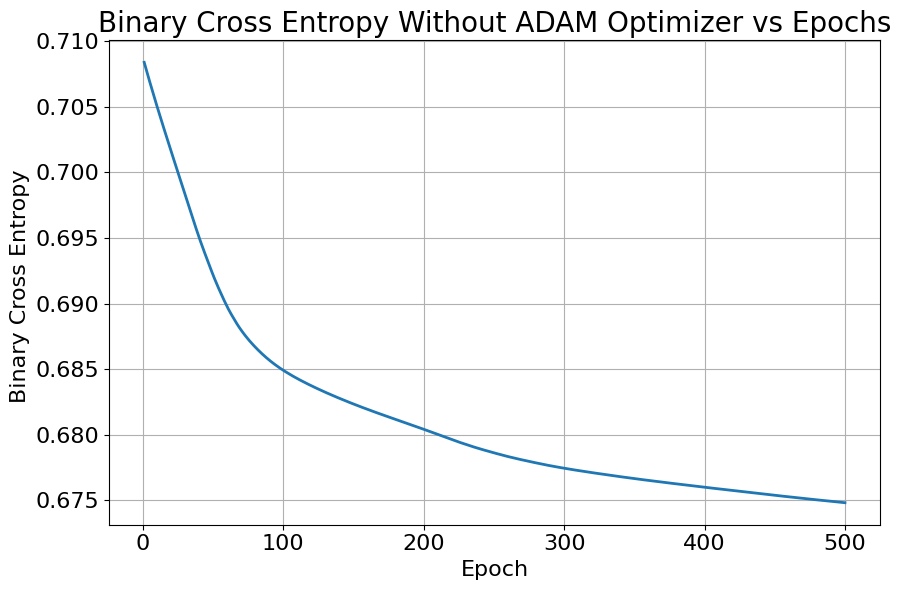

In [17]:
iterations = np.arange(1, len(training_ds_loss_history_1)+1)
plt.figure(figsize=(9, 6))
plt.plot(iterations, training_ds_loss_history_1, linewidth=2)
plt.title('Binary Cross Entropy Without ADAM Optimizer vs Epochs', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Binary Cross Entropy ', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('bce_wo_adam.png', dpi=300)
plt.show()

### Training With ADAM Optimizer

In [24]:
nn2 = NN(input_dim=X_train.shape[1], hidden_layer_neurons=[16, 8])

In [ ]:
training_ds_loss_history_2, testing_ds_loss_history_2 = nn2.train(X_train, y_train, X_test, y_test, epochs=500, lr=0.01, adam_optimizer=True)

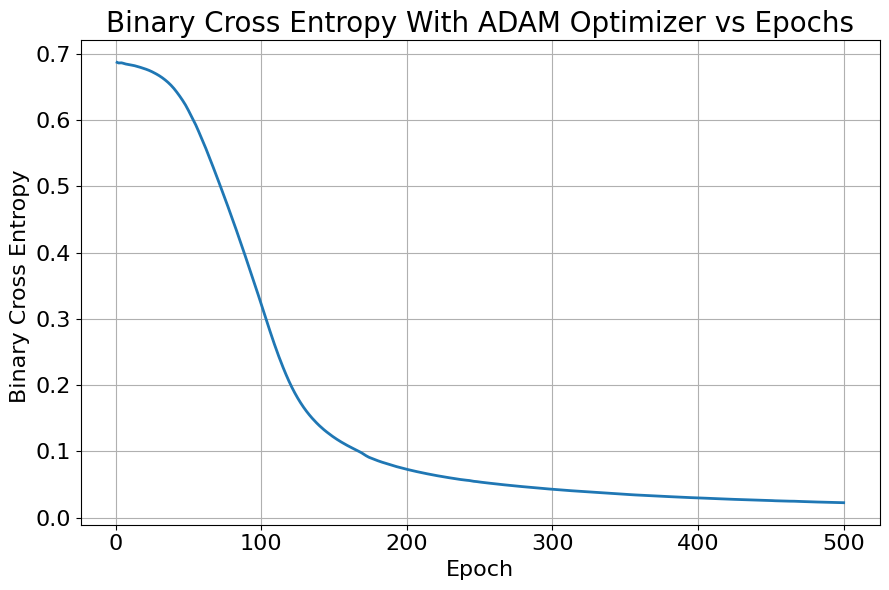

In [26]:
iterations = np.arange(1, len(training_ds_loss_history_2)+1)
plt.figure(figsize=(9, 6))
plt.plot(iterations, training_ds_loss_history_2, linewidth=2)
plt.title('Binary Cross Entropy With ADAM Optimizer vs Epochs', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Binary Cross Entropy ', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('bce_w_adam.png', dpi=300)
plt.show()